In [1]:
import numpy as np
import cv2
import tensorflow as tf
from numpy import load
from numpy import zeros
from numpy import ones
from numpy.random import randint
from numpy.random import randn
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Attention
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Layer
import tensorflow.keras.backend as K
from matplotlib import pyplot
from tensorflow.keras.utils import plot_model

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 11GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=11264)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
# define the discriminator model
def define_discriminator(image_shape, vector_shape, n_classes=7):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # source image input
    in_src_image = Input(shape=image_shape)
    # vector input
    in_target = Input(shape=(vector_shape[0], vector_shape[1]))
    # label input
    in_label = Input(shape=(1,))
    # Vector layer
    n_nodes = (image_shape[0] * image_shape[1] * image_shape[2])
    # embedding for categorical input
    li = Embedding(n_classes, 50)(in_label)
    # scale up to image dimensions with linear
    li = Dense(n_nodes)(li)
    # reshape to additional channel
    li = Reshape((image_shape[0], image_shape[1], image_shape[2]))(li)
    # LSTM Model
    p = LSTM(200, activation='relu')(in_target)
    p = Dense(n_nodes)(p)
    # Reshape and mergo to image dimension
    p = Reshape((image_shape[0], image_shape[1], image_shape[2]))(p)
    merged = Concatenate()([p, in_src_image, li])
    # concatenate images channel-wise
    # C64
    d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
    d = LeakyReLU(alpha=0.2)(d)
    # C128
    d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # C256
    d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # C512
    d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # second last output layer
    d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # patch output
    d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    d = Flatten()(d)
    d = Dropout(0.4)(d)
    out_layer = Dense(1, activation='sigmoid')(d)
    # define model
    model = Model([in_src_image, in_target, in_label], out_layer)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
    return model

In [4]:
# define an encoder block
def define_encoder_block(layer_in, n_filters, batchnorm=True):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # add downsampling layer
    g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same',
    kernel_initializer=init)(layer_in)
    # conditionally add batch normalization
    if batchnorm:
        g = BatchNormalization()(g, training=True)
    # leaky relu activation
    g = LeakyReLU(alpha=0.2)(g)
    return g

In [5]:
# define the standalone generator model
def define_generator(in_shape, vector_shape, latent_dim, n_classes=7):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # image input
    in_image = Input(shape=in_shape)
    in_lat = Input(shape=latent_dim)
    in_label = Input(shape=(1,))
    # embedding for categorical input
    li = Embedding(n_classes, 50)(in_label)
    li = Dense(latent_dim)(li)
    li = Reshape([latent_dim])(li)
    gen = LeakyReLU(alpha=0.2)(in_lat)
    # merge image gen and label input
    # encoder model
    e1 = define_encoder_block(in_image, 64, batchnorm=False)
    e2 = define_encoder_block(e1, 128)
    e3 = define_encoder_block(e2, 256)
    e4 = define_encoder_block(e3, 512)
    e5 = define_encoder_block(e4, 512)
    e6 = define_encoder_block(e5, 512)
    e7 = define_encoder_block(e6, 512)
    # bottleneck, no batch norm and relu
    b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
    b = Activation('relu')(b)
    b = Flatten()(b)
    # Merge latent space variable input with network
    b = Concatenate()([b, gen, li])
    # Reshape to vector size
    n_nodes = (vector_shape[0] * vector_shape[1])
    b = Dense(n_nodes)(b)
    b = Reshape([vector_shape[0], vector_shape[1]])(b)
    # encoder-decoder LSTM model
    d = Bidirectional(LSTM(200, activation='relu', return_sequences=True))(b)
    # output
    out_layer = Dense(3)(d)
    # define model input & output
    model = Model([in_image, in_lat, in_label], out_layer)
    return model

In [6]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model, image_shape, vector_shape, latent_dim):
    # make weights in the discriminator not trainable
    for layer in d_model.layers:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = False
    # define the source image
    in_src = Input(shape=image_shape)
    in_lat = Input(shape=latent_dim)
    in_label = Input(shape=(1,))
    # connect the source image to the generator input
    gen_out = g_model([in_src, in_lat, in_label])
    # connect the source input and generator output to the discriminator input
    dis_out = d_model([in_src, gen_out, in_label])
    # src image as input, generated image and classification output
    model = Model([in_src, in_lat, in_label], [dis_out, gen_out])
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100])
    return model

In [7]:
# load and prepare training images
def load_real_samples(filename):
	# load compressed arrays
	data = load(filename)
	# unpack arrays
	X1, X2, X3 = data['arr_0'], data['arr_1'], data['arr_2']
	return [X1, X2, X3-1]

In [8]:
# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples):
	# unpack dataset
	img, vec, label = dataset
	# choose random instances
	ix = randint(0, img.shape[0], n_samples)
	# retrieve selected images
	X1, X2, X3 = img[ix], vec[ix], label[ix]
	# generate 'real' class labels 
	y = ones((n_samples, 1))
	return [X1, X2, X3], y

In [9]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

In [10]:
# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, label, n_samples):
    # Generate latent space points
    z_input = generate_latent_points(latent_dim, n_samples)
    # generate fake instance
    X = g_model.predict([samples, z_input, label])
    # create 'fake' class labels 
    y = zeros((n_samples, 1))
    return X, y

In [11]:
# Overlay trajectories (data_y) to the image (data_x)
def create_trajectory(data_x, data_y, obs_len=10):
    # Calibration parameter to overlay for a 1280x360 resolution image
    K = np.array([[537.023764, 0, 640 , 0], 
                    [0 , 537.023764, 180, 0], 
                    [0, 0, 1, 0]])
    # Rotation matrix to obtain egocentric trajectory
    Rt = np.array([[0.028841, 0.007189, 0.999558, 1.481009],
                    [-0.999575,  0.004514,  0.028809,  0.296583],
                    [ 0.004305,  0.999964, -0.007316, -1.544537],
                    [ 0.      ,  0.      ,  0.      ,  1.      ]])

    # Resize data back to 1280x360
    data_x = cv2.resize(data_x, (1280,360))
    # Add column of ones for rotation matrix multiplication
    data_y = np.hstack((data_y, np.ones((len(data_y),1))))
    # Draw points
    for m in range(obs_len, data_y.shape[0]):
        # Rotation matrix multiplication of trajectory 
        A = np.matmul(np.linalg.inv(Rt), data_y[m, :].reshape(4, 1))
        # Egocentric view of trajectory
        B = np.matmul(K, A)
        # Circle location of trajectories 
        x = int(B[0, 0] * 1.0 / B[2, 0])
        y = int(B[1, 0] * 1.0 / B[2, 0])
        if (x < 0 or x > 1280 - 1 or y > 360 - 1):
            continue
        # Use opencv to overlay trajectories
        data_x = cv2.circle(data_x, (x, y), 3, (0, 0, 255), -1)
    return data_x

In [12]:
def generate_drvact_text(drvact):
    text = '[warnings] drvact label is not defined ...'
    if (drvact == 1):
        text = 'Go'
    elif (drvact == 2):
        text = 'Turn Left'
    elif (drvact == 3):
        text = 'Turn Right'
    elif (drvact == 4):
        text = 'U-turn'
    elif (drvact == 5):
        text = 'Left LC'
    elif (drvact == 6):
        text = 'Right LC'
    elif (drvact == 7):
        text = 'Avoidance'
    return text

In [13]:
# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, dataset, n_samples=1):
    # select a sample of input images
    [X_real_img, X_real_vec, X_label], _ = generate_real_samples(dataset, n_samples)
    # generate a batch of fake samples
    X_fake_vec, _ = generate_fake_samples(g_model, X_real_img, X_label, n_samples)
    # scale all pixels from [-1,1] to [0,1]
    X_real_img = (X_real_img + 1) / 2.0
    pyplot.figure(figsize=(32.0, 20.0))
    # plot real source images
    for i in range(n_samples):
        orig_image = (X_real_img[i]* 255).astype(np.uint8)
        orig_image = cv2.resize(orig_image, (1280,360))
        pyplot.subplot(3, n_samples, 1 + i)
        pyplot.axis('off')
        pyplot.imshow(orig_image)
    # plot generated target image
    for i in range(n_samples):
        fake_sample = create_trajectory((X_real_img[i]* 255).astype(np.uint8), X_fake_vec[i])
        pyplot.subplot(3, n_samples, 1 + n_samples + i)
        pyplot.axis('off')
        pyplot.imshow(fake_sample)
    # plot real target image
    for i in range(n_samples):
        true_sample = create_trajectory((X_real_img[i]* 255).astype(np.uint8), X_real_vec[i])
        pyplot.subplot(3, n_samples, 1 + n_samples*2 + i)
        pyplot.axis('off')
        pyplot.imshow(true_sample)
    # save plot to file
    filename1 = 'plot_%06d.png' % (step+1)
    pyplot.savefig(filename1)
    pyplot.close()
    # save the generator model
    filename2 = 'model_%06d.h5' % (step+1)
    g_model.save(filename2)
    print('>Saved: %s and %s' % (filename1, filename2))

In [14]:
# train models
def train(d_model, g_model, gan_model, dataset, latent_dim, n_epochs=100, batch_size=30):
    # iteration number to output checkpoint
    display_iter = 5000
    # calculate the number of batches
    n_batch = int(len(dataset[0]) / batch_size)
    # calculate the number of training iterations
    n_steps = n_batch * n_epochs
    # manually enumerate epochs
    for i in range(n_steps):
        # select a batch of real samples
        [X_real_img, X_real_vec, X_label], y_real = generate_real_samples(dataset, batch_size)
        # generate a batch of fake samples
        X_fake_vec, y_fake = generate_fake_samples(g_model, X_real_img, X_label, batch_size)
        # update discriminator for real samples
        d_loss1 = d_model.train_on_batch([X_real_img, X_real_vec, X_label], y_real)
        # update discriminator for generated samples
        d_loss2 = d_model.train_on_batch([X_real_img, X_fake_vec, X_label], y_fake)
        X_lat = generate_latent_points(latent_dim, batch_size)
        # update the generator
        g_loss, _, _ = gan_model.train_on_batch([X_real_img, X_lat, X_label], [y_real, X_real_vec])
        # summarize performance
        print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
        # summarize model performance
        #if (i+1) % int(bat_per_epo) == 0:
        if (i+1) % int(display_iter) == 0:
            summarize_performance(i, g_model, dataset)
            print('saved')

In [16]:
%%time
# load image data
dataset = load_real_samples('./dual_condition_dataset_train.npz')
print('Loaded', dataset[0].shape, dataset[1].shape, dataset[2].shape)

Loaded (16805, 256, 256, 3) (16805, 40, 3) (16805,)
CPU times: user 23.2 s, sys: 3.59 s, total: 26.7 s
Wall time: 27 s


In [17]:
# define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]
vector_shape = dataset[1].shape[1:]
latent_dim = 512
# %%
# define the models
d_model = define_discriminator(image_shape, vector_shape)
g_model = define_generator(image_shape, vector_shape, latent_dim)
# %%
# define the composite model
gan_model = define_gan(g_model, d_model, image_shape, vector_shape, latent_dim)

In [18]:
#see model summary
print(g_model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 128, 128, 64) 3136        input_4[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_7 (LeakyReLU)       (None, 128, 128, 64) 0           conv2d_6[0][0]                   
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 64, 64, 128)  131200      leaky_re_lu_7[0][0]              
____________________________________________________________________________________________

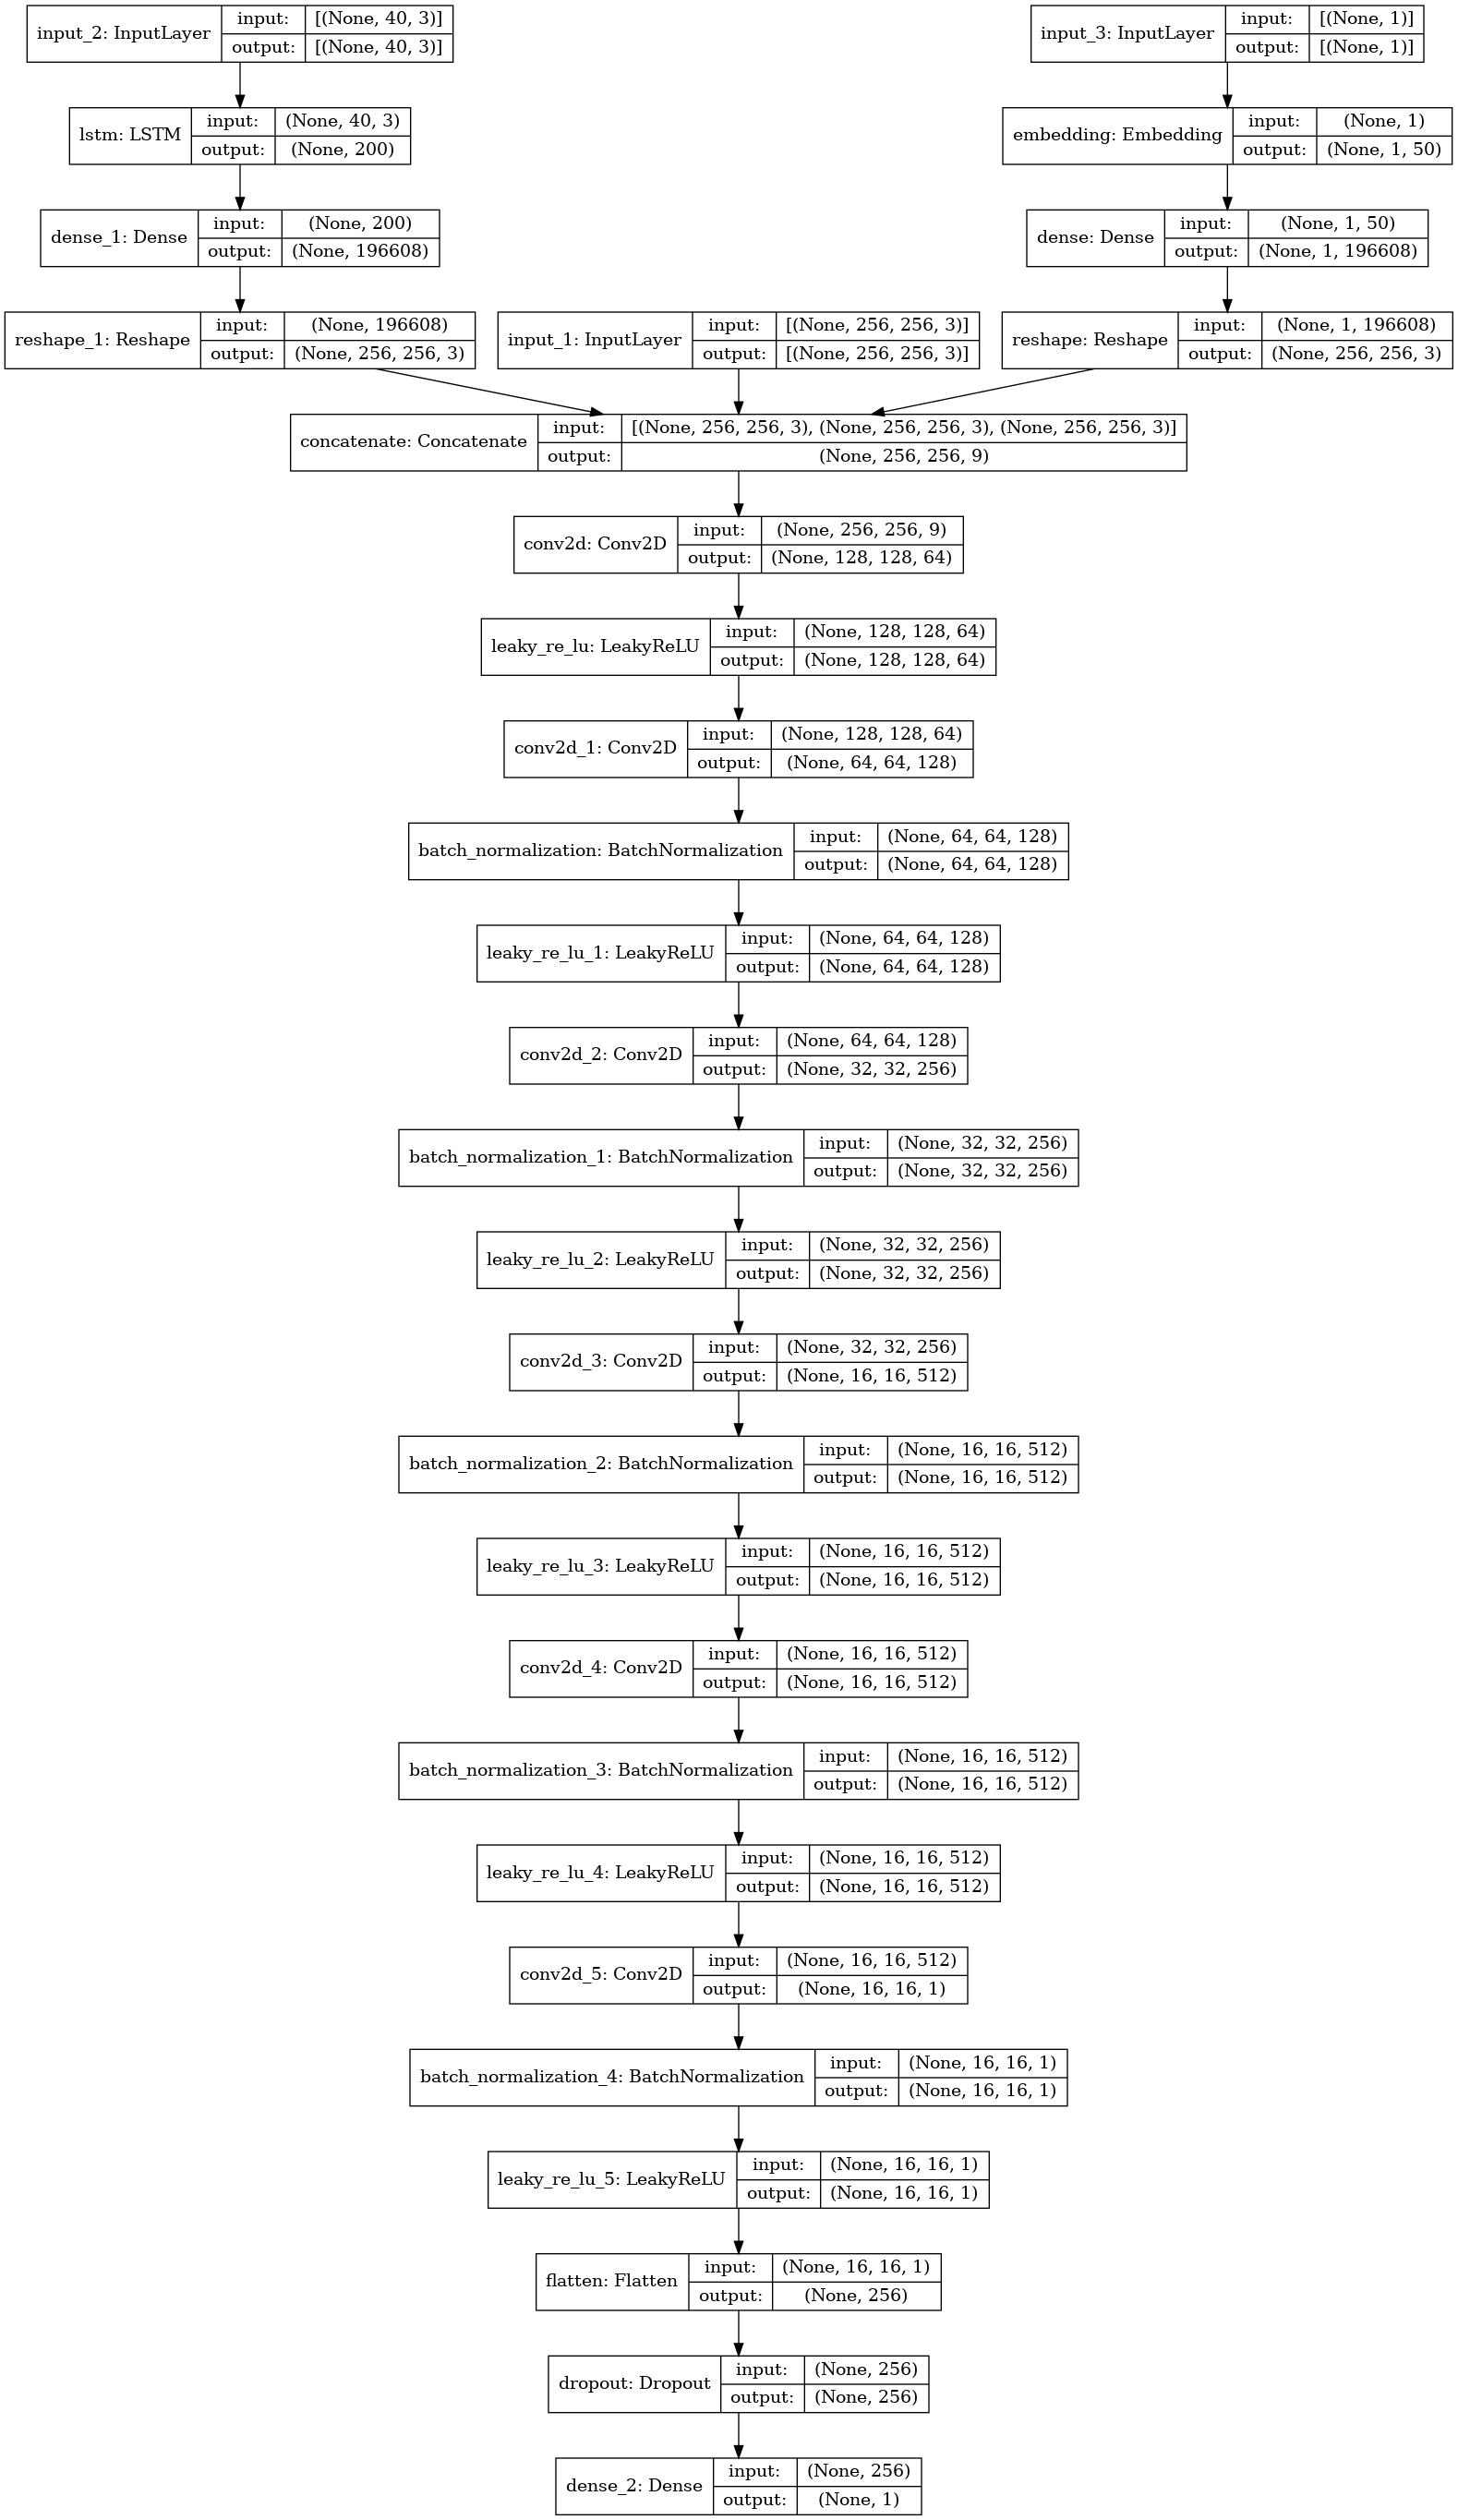

In [26]:
plot_model(d_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [18]:
# train model
train(d_model, g_model, gan_model, dataset, latent_dim)

>1, d1[0.855] d2[1.096] g[433.070]
>2, d1[0.160] d2[0.320] g[329.660]
>3, d1[0.086] d2[0.329] g[463.398]
>4, d1[0.114] d2[0.221] g[374.066]
>5, d1[0.105] d2[0.203] g[427.226]
>6, d1[0.103] d2[0.239] g[340.183]
>7, d1[0.095] d2[0.231] g[339.296]
>8, d1[0.039] d2[0.149] g[354.877]
>9, d1[0.066] d2[0.159] g[367.557]
>10, d1[0.064] d2[0.166] g[334.578]
>11, d1[0.074] d2[0.194] g[334.349]
>12, d1[0.037] d2[0.191] g[304.049]
>13, d1[0.126] d2[1.084] g[252.868]
>14, d1[0.459] d2[0.300] g[242.370]
>15, d1[0.764] d2[0.249] g[289.139]
>16, d1[0.669] d2[0.118] g[320.048]
>17, d1[0.512] d2[0.208] g[257.974]
>18, d1[0.361] d2[0.315] g[237.215]
>19, d1[0.242] d2[0.498] g[229.868]
>20, d1[0.403] d2[0.342] g[217.495]
>21, d1[0.428] d2[0.310] g[203.334]
>22, d1[0.544] d2[0.428] g[194.178]
>23, d1[0.498] d2[0.272] g[174.626]
>24, d1[0.556] d2[0.247] g[186.788]
>25, d1[0.517] d2[0.382] g[178.985]
>26, d1[0.438] d2[0.399] g[249.316]
>27, d1[0.456] d2[0.336] g[146.297]
>28, d1[0.498] d2[0.239] g[142.458]
>

>227, d1[0.365] d2[0.308] g[96.365]
>228, d1[0.387] d2[0.300] g[99.845]
>229, d1[0.393] d2[0.312] g[58.312]
>230, d1[0.398] d2[0.325] g[83.037]
>231, d1[0.395] d2[0.328] g[67.782]
>232, d1[0.411] d2[0.294] g[96.289]
>233, d1[0.410] d2[0.330] g[105.522]
>234, d1[0.346] d2[0.342] g[80.205]
>235, d1[0.364] d2[0.325] g[80.790]
>236, d1[0.387] d2[0.342] g[104.887]
>237, d1[0.345] d2[0.339] g[96.251]
>238, d1[0.429] d2[0.298] g[86.860]
>239, d1[0.396] d2[0.342] g[72.520]
>240, d1[0.368] d2[0.332] g[101.075]
>241, d1[0.359] d2[0.307] g[108.587]
>242, d1[0.362] d2[0.336] g[82.022]
>243, d1[0.359] d2[0.351] g[109.813]
>244, d1[0.341] d2[0.280] g[129.415]
>245, d1[0.358] d2[0.324] g[93.062]
>246, d1[0.412] d2[0.289] g[65.773]
>247, d1[0.379] d2[0.345] g[76.071]
>248, d1[0.361] d2[0.338] g[97.582]
>249, d1[0.384] d2[0.298] g[104.061]
>250, d1[0.339] d2[0.331] g[96.720]
>251, d1[0.388] d2[0.300] g[67.656]
>252, d1[0.375] d2[0.318] g[89.528]
>253, d1[0.364] d2[0.336] g[94.894]
>254, d1[0.369] d2[0.

KeyboardInterrupt: 

In [19]:
#end the tensorflow session
from tensorflow.keras import backend as K
K.clear_session()

In [20]:
#for cuda to release GPU memory
from numba import cuda
cuda.select_device(0)
cuda.close()

# 